In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
#import fbprophet
#from fbprophet import Prophet
from datetime import date,timedelta

df = pd.read_csv('covid_us.csv')
df.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

plt.rcParams['figure.figsize']=(12,6)
plt.style.use('ggplot')

In [4]:
df_American_Samoa = df[df['subregion1_name'] == 'American Samoa'].index.tolist()
df_District_of_Columbia = df[df['subregion1_name'] == 'District of Columbia'].index.tolist()
df_Guam = df[df['subregion1_name'] == 'Guam'].index.tolist()
df_Northern_Mariana_Islands = df[df['subregion1_name'] == 'Northern Mariana Islands'].index.tolist()
df_Puerto_Rico = df[df['subregion1_name'] == 'Puerto Rico'].index.tolist()
df_Virgin_Islands = df[df['subregion1_name'] == 'Virgin Islands'].index.tolist()
df.drop(df_American_Samoa, inplace = True)
df.drop(df_District_of_Columbia, inplace = True)
df.drop(df_Guam, inplace = True)
df.drop(df_Northern_Mariana_Islands, inplace = True)
df.drop(df_Puerto_Rico, inplace = True)
df.drop(df_Virgin_Islands, inplace = True)


#remove all subregion1_name not in 50 states

In [5]:
x = sorted(df['subregion1_name'].unique())
d = {'states' : x}
us_states = pd.DataFrame(data = d)

df = df.sort_values(['subregion1_name', 'date'])
df.reset_index(inplace = True)

#df.dtypes

In [6]:
df = df.fillna(0)                                               #replace all columns with NA in df to 0


#df['total_tested'] = df['total_tested'].fillna(0) 
df['total_confirmed'] = df['total_confirmed'].astype(np.int64)



In [7]:
new_date = []
for i in range(df.shape[0]):
    new_date.append(int("".join(df.loc[i, 'date'].split('-'))))
new_date
df['new_date'] = new_date

#df.head()
#df.dtypes

In [8]:
i = 1
ndays = []
for n in range(df.shape[0]):
    if i == 483:
        i = 1
        ndays.append(i)
        i +=1
    else: 
        ndays.append(i)
        i += 1
df['ndays'] = ndays
#df['date'] = pd.to_datetime(df['date'])



In [9]:
states_by_indices = []
i = 0

for n in range(df.shape[0]):
    if df.loc[n, 'subregion1_name'] == us_states.loc[i, 'states']:
        states_by_indices.append(i)
    else:
        i += 1
        states_by_indices.append(i)
        
states_by_indices


dict = {}
for i in us_states['states']:
    dict["df_{0}".format(i)] = df[df['subregion1_name'] == i]            #store the df_states inside a dictionary
                                                                         #key is df_states, value is the dataframe associated with that state
#dict["df_West Virginia"]                                                 #example: dict["df_West Virginia"] gets the dataframe for all rows with subregion1_name = West Virginia 

for key in dict:
    dict[key] = dict[key].reset_index()                                  #reset the index of df_states for easier manipulation of data

In [10]:
class LinearRegression:
    def __init__(self):
        self.b = []
        self.X = []     
        return      
    
    def fit(self, x, y, order): 
        
        self.index = 0
        
        self.X = np.c_[np.ones(len(x))]   #initialize X as a matrix having columns of ones. This corresponds to polynomial of order 0
        while True:
            if self.index < order and order != 0:                          #concatenate power of x to original matrices X
                self.index += 1
                self.X = np.c_[self.X, np.power(x, self.index)]
            
            else:
                break
        self.b = np.linalg.inv(self.X.T@self.X)@(self.X.T@y)           # w = (X^T*X)^-1*(X^T*y) Formula given in lecture
        
        
        return self.X, self.b
    
    def predict(self):
        
        predict_array = self.X@self.b                  #prediction array is just X*w
        
        return predict_array
    
    def mse(self, y, predict_array):
        
        self.mse_array = y - predict_array
        
        self.mse = np.power(self.mse_array, 2)
        
        return np.sum(self.mse)/len(y)

In [11]:
def FitOrder(x,y):                                                #optimization for finding the order that corresponds with minimum mse
    new_order = []
    for i in range(310):
        linear = LinearRegression()
        linear.fit(x,y,i)
        prediction = linear.predict()
        new_order.append(linear.mse(y,prediction))
    index_order = new_order.index(min(new_order))
    return index_order

In [12]:
def StateLinearRegression(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    
    for i in list(df.columns):
        if i == input_col:
            y = np.array(df_state[i][start_day:end_day+1])
            break
    #y = np.array(df_state['total_confirmed'][:480])
    order = FitOrder(x,y)                                                                            #Used 400 samples as training set
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    b = model.mse(y, n)
    
    plt.rcParams['figure.figsize'] = (12,6)
    plt.scatter(x,y, s = 5, color = 'tab:blue')
    plt.plot(x,n, color = 'r')
    plt.ticklabel_format(style = 'plain')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days')
    plt.ylabel(input_col)
    plt.title("{} Covid-19 Cases".format(state))
    plt.show()
    
    return b, order
    

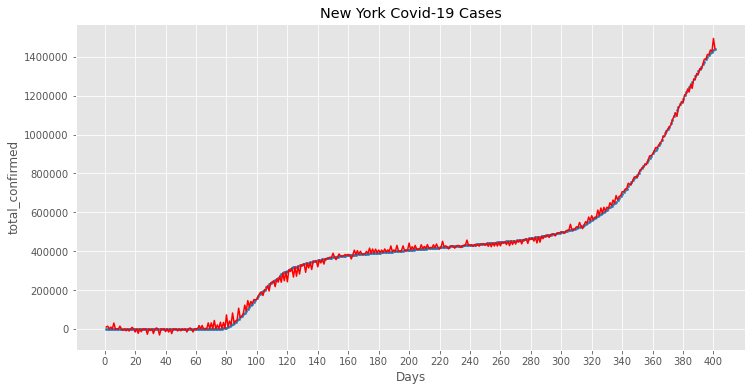

In [13]:
hello = StateLinearRegression("New York", 'total_confirmed', 0, 400)

In [14]:
print("The Mean Square Error is", hello[0], 'and the order of fit is', hello[1])

The Mean Square Error is 226285518.0419846 and the order of fit is 261


In [15]:
def PlotBar(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
        
    plt.rcParams['figure.figsize'] = (12,6)
    plt.bar(list(x), list(y), color='tab:blue')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days', size = 10)
    plt.ylabel(input_col, size = 10)
    plt.title("{0}'s Bar plot of Days vs {1}".format(state, input_col), size = 10)
    plt.show()
    

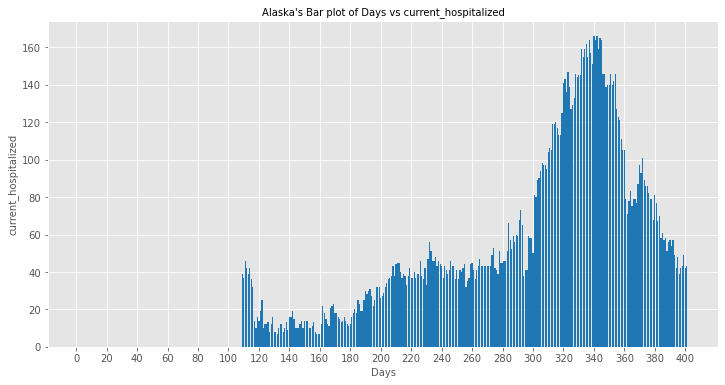

In [16]:
PlotBar("Alaska", 'current_hospitalized', 1, 400)

In [17]:
def BarAndRegression(state, input_col, start_day, end_day):
    PlotBar(state, input_col, start_day, end_day)
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
    
    order = FitOrder(x,y)
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    plt.plot(x,n, color = 'r')
    plt.title("{0}'s Bar plot and Regression of Days vs {1}".format(state, input_col), size = 10)
    plt.show()

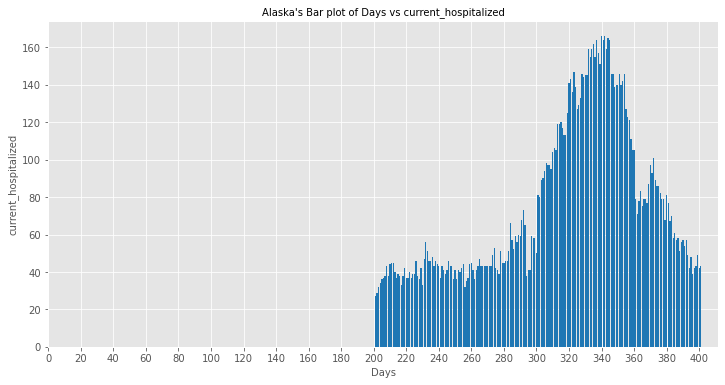

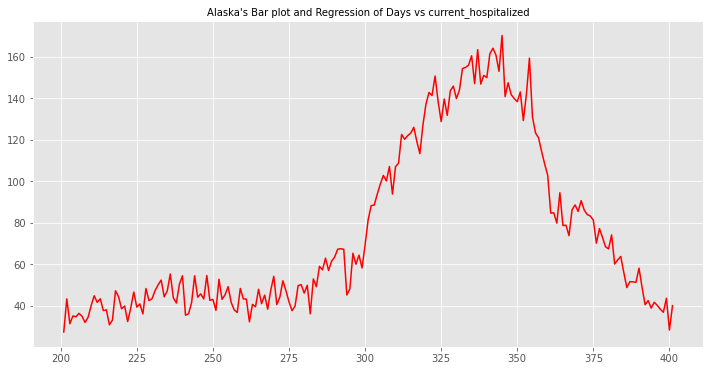

In [18]:
 BarAndRegression("Alaska", 'current_hospitalized', 200, 400)

In [19]:
def Stateinfo(state, day):                                         #Display the info at a specific state and day
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    df_new = df_state[df_state['ndays']==day ]
    #df_new = pd.DataFrame.transpose(df_new)
    df_new = df_new.T
    df_new.rename({day-1:state}, axis = 1, inplace = True) 
    
    df_new.drop('level_0', inplace = True)
    df_new.drop('country_name', inplace = True)
    df_new.drop('index', inplace = True)
    df_new.drop('new_date', inplace = True)
    df_new.drop('population_age_00_09', inplace = True)
    df_new.drop('population_age_10_19', inplace = True)
    df_new.drop('population_age_20_29', inplace = True)
    df_new.drop('population_age_30_39', inplace = True)
    df_new.drop('population_age_40_49', inplace = True)
    df_new.drop('population_age_50_59', inplace = True)
    df_new.drop('population_age_60_69', inplace = True)
    df_new.drop('population_age_70_79', inplace = True)
    df_new.drop('population_age_80_89', inplace = True)
    df_new.drop('population_age_90_99', inplace = True)
    df_new.drop('population_age_80_and_older', inplace = True)
    df_new.drop('locality_name', inplace = True)
    df_new.drop('subregion1_name', inplace = True)
    df_new.drop('population_male', inplace = True)
    df_new.drop('population_female', inplace = True)
    df_new = df_new[df_new[state]!=0]
    
    return df_new

In [20]:
 Stateinfo('New York', 100)

,New York
date,2020-04-09
new_confirmed,10621
new_deceased,799
new_tested,26396
total_confirmed,159937
total_deceased,7067
total_tested,391549
new_hospitalized,2870
total_hospitalized,42852
current_hospitalized,18279


In [21]:
#   Commented out--fbprophet is being difficult.
# 
#  class TimeSeriesForecast:
    
#     def __init__(self):    
        
#         self.viz_df =[]
#         self.last_date = []
#         self.df_state = []
#         self.prediction = []
#         self.forecast = []
#         self.state = []
#         self.input_col = []
        
#         return   
   
#     def Statepredict(self, state, input_col):
#         for key in dict:
#             if dict[key]['subregion1_name'][0] == state:
#                 self.df_state = dict[key]
#                 break
        
#         self.state = state
#         self.input_col = input_col
#         self.df_state = self.df_state = self.df_state[['date', input_col]]
#         self.df_state.columns = ['ds', 'y']
#         model = Prophet()
#         model.fit(self.df_state) 
#         future_dates = model.make_future_dataframe(periods = 100)          #adding 100 days/datetime to the dataframe
#         self.prediction = model.predict(future_dates)
#         self.df_state.set_index('ds', inplace=True)
#         self.last_date = self.df_state.index[-1]
#         self.prediction.set_index('ds', inplace=True)
#         self.df_table = self.df_state.join(self.prediction[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    
#     def plot_data(self):
#         self.last_date = self.last_date - timedelta(weeks=4) 
#         forecast_index= (self.df_table.index > self.last_date) #  pull out the predicted/forecast rows of data.
#         self.forecast = self.df_table.loc[forecast_index]       # create a new dataframe with predicted/forecast data.
        
#         fig, ax1 = plt.subplots()
#         ax1.ticklabel_format(useOffset=False, style='plain')
#         ax1.plot(self.df_state.y[:453])
#         ax1.plot(self.prediction.yhat)
#         ax1.plot(self.forecast.yhat, color='purple')
        
#         ax1.fill_between(self.forecast.index, self.forecast['yhat_upper'], self.forecast['yhat_lower'], alpha=0.5, color='darkgrey')
        
#         ax1.set_ylabel(self.input_col)
#         ax1.set_xlabel('Date')
#         ax1.set_title("{0}: Datetime vs {1} forecast plot".format(self.state, self.input_col))
#         ax1.legend(['original data', 'prediction', 'forecast']) 
    

In [22]:
# def CallTimeSeriesForecast(state, input_col):
#     mod = TimeSeriesForecast()
#     mod.Statepredict(state, input_col)
#     mod.plot_data()
#     return mod.prediction

In [23]:
# model = CallTimeSeriesForecast('New York', 'total_confirmed')

In [24]:
# ARIMA Forecasting

df = df.set_index('date')
df= df.drop(columns = 'index')
df.head()

,country_name,subregion1_name,locality_name,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,...,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_89,population_age_90_99,population_age_80_and_older,new_date,ndays
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200101,1
2020-01-02,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200102,2
2020-01-03,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200103,3
2020-01-04,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200104,4
2020-01-05,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200105,5


In [25]:
#function for creating a dataframe for a specific state (with date as index)
def createStateDF(state):
  df_state = df[df["subregion1_name"] == state]
  return df_state

In [26]:
df_california = createStateDF("California")

In [27]:
#testing for stationarity
from statsmodels.tsa.stattools import adfuller
def stationarityTest(state, input): 
  df_test_state = createStateDF(state)
  series_test_stationarity = df_test_state[input]
  stationaritytest = adfuller(series_test_stationarity, autolag = 'AIC')
  print('Augmented Dickey-Fuller Statistic: %f' % stationaritytest[0])  
  print('p-value: %f' % stationaritytest[1])  
  # null hypothesis testing
  if(stationaritytest[1] < .05):
    print("Data is stationary!")
  else: 
    print("Data is not stationary!")
  df_test_plot = df_test_state[[input]]
  df_test_plot.plot()

Augmented Dickey-Fuller Statistic: -2.197983
p-value: 0.206978
Data is not stationary!


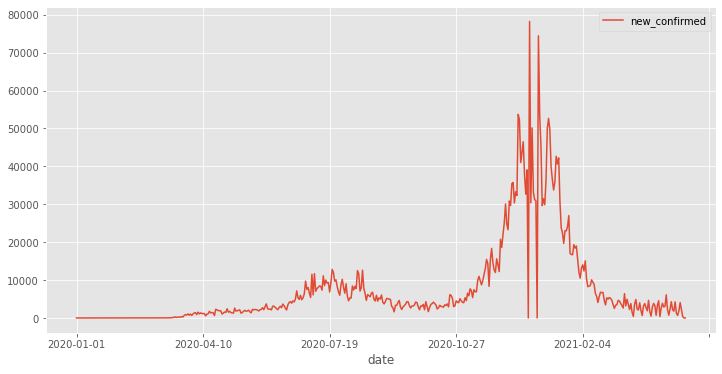

In [28]:
stationarityTest('California', 'new_confirmed')
# Data is not stationary--this should be taken care of in the third 'd' parameter in the ARIMA model.

In [29]:
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error


# This is all code from the Google colab. I kept it in for the moment.

X = df_california['new_confirmed'].tolist()
size = int(len(X) * 0.66)

train, test = X[0:size], X[size:len(X)]
stepwise_fit = auto_arima(df_california['total_confirmed'])           # set to stepwise
stepwise_fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  482
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6477.383
Date:                Thu, 20 May 2021   AIC                          12956.766
Time:                        00:46:38   BIC                          12960.942
Sample:                             0   HQIC                         12958.407
                                - 482                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.907e+10   1.22e+08    239.076      0.000    2.88e+10    2.93e+10
===================================================================================
Ljung-Box (Q):                        0.35   Jarque-Bera (JB):           4490433.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):           52000.03   Skew:                           -21.70
Prob(H) (two-sided):                  0.00   Kurtosis:                       474.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

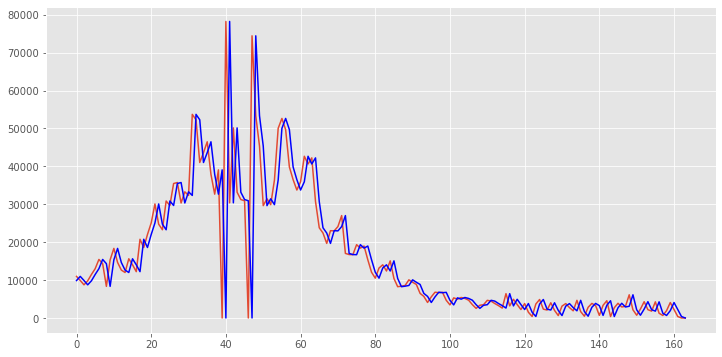

In [30]:
# stepwise_fit.plot_diagnostics(figsize=(7,5))
# plt.show()

# model = ARIMA(df_california['new_confirmed'], order=(0,1,0))
# model_fit = model.fit()
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()

X = df_california['new_confirmed'].tolist()
size = int(len(X) * 0.66)

history = [x for x in train]
predictions = list()

for t in range(len(test)):
  model = ARIMA(history, order=(0,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='blue')
pyplot.show()

In [31]:
# Accuracy metrics printout. Currently, there are problems with dividing by 0. May have to remove all rows where there are 0s in the actual data.
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # ACF1 wasn't working so I cut it
    #acf1 = acf(fc-test)[1]
    print("Mean Absolute Percent Error: ", mape)
    print("Mean Error :", me)
    print("Mean Absolute Error: ", mae)
    print("Mean Percentage Error: ", mpe)
    print("Root Mean Squared Error: ", rmse)
    #print("Lag 1 Autocorrelation of Error: ", acf1)
    print("Correlation between the Actual and the Forecast: ", corr)
    print("Min-Max Error: ", minmax)
    #print("Mean Absolute Percent Error: %f; Mean Error: %f; Mean Absolute Error: %f; Mean Percentage Error: %f; Root Mean Squared Error: %f; Lag 1 Autocorrelation of Error: %f; Correlation between the Actual and the Forecast: %f; Min-Max Error: %f" % (mape, me, mae, mpe, rmse, acf1, corr, minmax))                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [32]:
# This automates the above example so we can input any state and col
# There's a fun bug where sometimes, the ideal order found through auto_arima makes the model not converge in the second part that's commented out. debug/try-catch?
# Outputs the prediction based on all the data in the handy plot. Outputs accuracy metrics. For some reason, the division stuff isn't working. 
# 2. I would like to add the predicted value for the current date.
# 3. We need to add accuracy metrics (maybe check the data is appropriate with residuals, etc.)
from statsmodels.tsa.arima_model import ARIMA

def buildForecast(state, input_col):
    df_state = createStateDF(state)
    model = pm.auto_arima(df_state[input_col], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    order=model.order
    model = ARIMA(df_state[input_col], order=order)
    model_fit = model.fit(disp=0) #fits ARIMA by exact maximum likelihood

    # Plot forecast from all data (no training/test split involved)
    model_fit.plot_predict(end=date.today(),dynamic=False)
    plt.show()

    # I need to drop 0s from fc to get the percent erros and such
    # 1. drop indices from df_state where df_state[input_col]
    # 2. can track the kept indices
    # 3. drop those indices from model_fit?

    final_fc = model_fit.predict(start=model_fit.fittedvalues.index[0], end=date.today(), typ = 'levels').values[0]
    fc = model_fit.predict(start=model_fit.fittedvalues.index[0], end=model_fit.fittedvalues.index[-1], typ = 'levels').values

    # Accuracy estimates, input forecast and the actual data starting from the first date which the fitted values start at
    forecast_accuracy(fc, df_state[input_col][model_fit.fittedvalues.index[0]:])

    # Print out final prediction
    print("Final estimate on ", date.today(), " is: ",  final_fc)

    # Potentially cut everything below!
    # If we keep: implement a try-catch for LinAlgError: SVD Did Not Converge
    # Training/testing split
    # size = int(len(df_state[input_col]) * 0.75)  
    # train = df_state[input_col][:size]
    # test = df_state[input_col][size:]

    # Build Model Based On 75% Training Data
    # model = ARIMA(train, order=order)  
    # fitted = model.fit(disp=-1)  

    # Forecast
    # fc, se, conf = fitted.forecast(121, alpha=0.05)  # 95% conf

    # Make as pandas series
    # fc_series = pd.Series(fc, index=test.index)
    # lower_series = pd.Series(conf[:, 0], index=test.index)
    # upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    # plt.figure(figsize=(12,5), dpi=100)
    # plt.plot(train, label='training')
    # plt.plot(test, label='actual')
    # plt.plot(fc_series, label='forecast')
    # plt.fill_between(lower_series.index, lower_series, upper_series, 
    #              color='k', alpha=.15)
    # plt.title('Forecast vs Actuals')
    # plt.legend(loc='upper left', fontsize=8)
    # plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9072.828, Time=0.68 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9397.058, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9095.957, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9071.255, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9395.062, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=9074.402, Time=0.89 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=9074.126, Time=1.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 3.390 seconds
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so

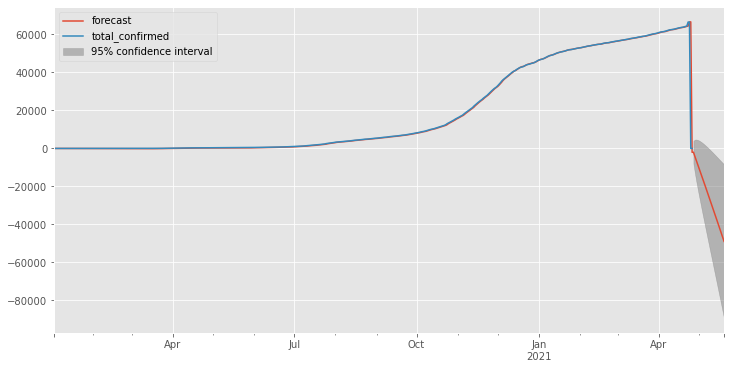

Mean Absolute Percent Error:  inf
Mean Error : -5.586577883998219
Mean Absolute Error:  292.3340491237581
Mean Percentage Error:  nan
Root Mean Squared Error:  3047.7572805929053
Correlation between the Actual and the Forecast:  0.9916113602603136
Min-Max Error:  inf
Final estimate on  2021-05-20  is:  -4.4126200924744055
<ipython-input-31-b5bff856283c>:13: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


In [33]:
buildForecast("Alaska", 'total_confirmed')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9564.682, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9820.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9619.179, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9573.244, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9818.879, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9561.283, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9607.047, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9553.640, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9598.417, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9483.029, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9560.026, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9531.389, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9530.407, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=9481.015, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0]          

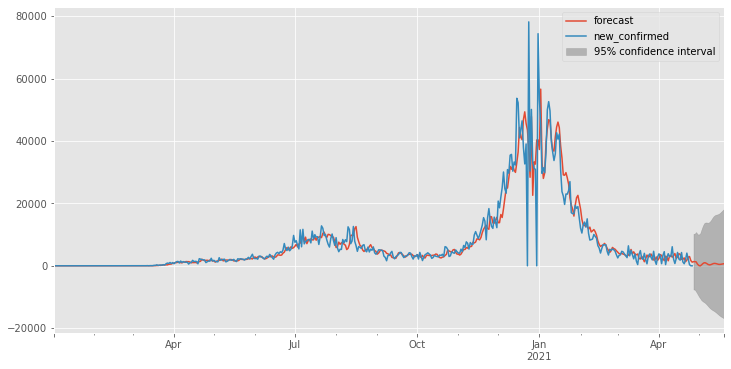

Mean Absolute Percent Error:  inf
Mean Error : -3.376910476663245
Mean Absolute Error:  1750.4166346087077
Mean Percentage Error:  nan
Root Mean Squared Error:  4548.914710252913
Correlation between the Actual and the Forecast:  0.9184625616958308
Min-Max Error:  inf
Final estimate on  2021-05-20  is:  0.001243853464953817
<ipython-input-31-b5bff856283c>:13: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


In [34]:
buildForecast("California", 'new_confirmed')

In [35]:
# Josh code, makes a class, does current estimations. I'm thinking we cut this, though it is nicely divided up.
# import pmdarima as pm
# from pmdarima import auto_arima
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import acf
# from matplotlib import pyplot
# from math import sqrt
# from sklearn.metrics import mean_squared_error

# class stateARIMA:
#   def __init__(self, state):
#     self.df_state = createStateDF(state)
#     self.train = {}
#     self.test = {}

#   def splitData(self,  input, trainprop):
#     X = self.df_state[input].tolist()
#     size = int(len(X) * trainprop)
#     train, test = X[0:size], X[size:len(X)]
#     self.train = train
#     self.test = test

#   def findARIMAParams(self, input):
#     stepwise_fit = auto_arima(self.df_state[input], 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
#     return stepwise_fit.order

#   def buildARIMA(self, input, model_order): 
#     history = [x for x in self.train]
#     predictions = list()
#     for t in range(len(self.test)):
#       model = ARIMA(history, order = (0,1,0))
#       model_fit = model.fit()
#       output = model_fit.forecast()
#       yhat = output[0]
#       predictions.append(yhat)
#       obs = self.test[t]
#       history.append(obs)
#       #print('predicted=%f, expected=%f' % (yhat, obs))
#     rmse = sqrt(mean_squared_error(self.test, predictions))
#     print(rmse)
#     # plot forecasts against actual outcomes
#     pyplot.plot(self.test)
#     pyplot.plot(predictions, color='blue')
#     pyplot.show()

#   def qeARIMA(self, input, trainprop): 
#     self.splitData(input, trainprop)
#     order = self.findARIMAParams(input)
#     self.buildARIMA(input, order)

# californiaARIMA = stateARIMA('California')
# californiaARIMA.qeARIMA('new_confirmed', 0.7)

In [36]:
# This is based on code from here. https://machinelearningmastery.com/make-sample-forecasts-arima-python/
# It outputs a forecast, but doesn't really have a method of outputting accuracy metrics and has a seasonal component built in, which we don't want.
# We'll probably cut it.

# takes the seasonal difference by taking the observation at a particular day and subtracting the observation from one [interval] ago
# def difference(dataset, interval=1):
# 	diff = list()
# 	for i in range(interval, len(dataset)):
# 		value = dataset[i] - dataset[i - interval]
# 		diff.append(value)
# 	return np.array(diff)
 
# # invert differenced value to make forecasts
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]

# def findOrder(df_state_col):
#     stepwise_fit = auto_arima(df_state_col, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
#     return stepwise_fit.order
 
#  # makes a multi-step out of sample forecast to arrive at a forecast up to the current day at midnight
# def buildForecastNew(state, input_col):
#     df_state = createStateDF(state)
#     # seasonal difference
#     X = df_state[input_col]
#     days_in_year = 365
#     differenced = difference(X, days_in_year)
#     # fit model
#     order = findOrder(X)
#     model = ARIMA(differenced, order=order)
#     # model = ARIMA(X, order=(1,1,1)) 
#     model_fit = model.fit()
#     # multi-step out-of-sample forecast
#     start_index = len(differenced)
#     # start_index = len(X) 
#     day_range = date.today() - date(2021, 4, 27)
#     end_index = start_index + day_range.days
#     forecast = model_fit.predict(start=start_index, end=end_index, typ = 'levels')
#     # invert the differenced forecast to something usable
#     history = [x for x in X]
#     day = 1
#     inverted = []
#     for yhat in forecast:
# 	    inverted += [inverse_difference(history, yhat, days_in_year)]
# 	    history.append(inverted)
# 	    day += 1

#     dates = pd.date_range(start="2021-04-27",end=date.today())

#     data = {'date':dates, 'forecast':inverted}
#     # data = {'date':dates, 'forecast':forecast}

#     forecast_df = pd.DataFrame(data)
#     forecast_df = forecast_df.set_index('date')

#     frames = [df_state, forecast_df]

#     result = pd.concat(frames)
#     result[[input_col,'forecast']].plot(figsize=(12,8))

In [37]:
# buildForecastNew('California', 'new_confirmed')

In [38]:
# buildForecastNew('Alabama', 'new_deceased')